# Setting up our imports and globals
The purpose of this section is to initialize the notebook with everything we will need for our analysis.

This includes adding in some file paths as variables. There is some magic in here to make sure that the output goes directly into your student directory in the course directory.

You don't/shouldn't have to change of these settings and variables for the tutorial. 

However, for the assignment, you are tasked with performing a similar analysis on the Liaw lab data. When you get to that point, you may want to try to understand what is going on with the paths here.

In [2]:
import os
import grp
import math
import anndata
import warnings
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
from pathlib import Path
import matplotlib as mpl
import matplotlib.pyplot as plt

# These next parts are for removing some noise from the output so as to not confuse the information.
sc.settings.verbosity = 0
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=anndata.ImplicitModificationWarning)
sc.settings.set_figure_params(dpi=80)

In this block below, we are setting some file paths as variables. However, something here may be new to you. I didn't "hard-code" (e.g., `/home/user/folder/file.txt`). Instead, I used what is called a `pathlib.Path` object. The `Path` object lets me create paths that _should_ work on any operating system. The more and more that you get into tool development or creating reports that others may need to collaborate on, you may have to consider the ways other computers may interact.

In [3]:
user_name = os.environ.get('USER')
user_group = 'staff' if 700181 in os.getgroups() else "student" # Magic to get the correct output paths setup.

class_directory = Path('/', 'courses', 'BINF6430.202510')
student_directory = Path(class_directory, user_group, user_name)
results = Path(student_directory, "write", "pbmc43k.h5ad")


data_sample_list = ['49-AdipoB', '49-DM', '916-AdipoB', '916-DM']

### Data
data_1 = Path(class_directory, 'data', 'LiawData', '10x_FRP_12-16-22',
            'analysis', 'MMC-1', 'outs', 'per_sample_outs', '49-AdipoB', 'count', 'sample_raw_feature_bc_matrix')

data_2 = Path(class_directory, 'data', 'LiawData', '10x_FRP_12-16-22',
            'analysis', 'MMC-1', 'outs', 'per_sample_outs', '49-DM', 'count', 'sample_raw_feature_bc_matrix')

data_3 = Path(class_directory, 'data', 'LiawData', '10x_FRP_12-16-22',
            'analysis', 'MMC-1', 'outs', 'per_sample_outs', '916-AdipoB', 'count', 'sample_raw_feature_bc_matrix')

data_4 = Path(class_directory, 'data', 'LiawData', '10x_FRP_12-16-22',
            'analysis', 'MMC-1', 'outs', 'per_sample_outs', '916-DM', 'count', 'sample_raw_feature_bc_matrix')

# /courses/BINF6430.202510/data/LiawData/10x_FRP_12-16-22/analysis/MMC-1/outs/per_sample_outs/916-DM/count/sample_raw_feature_bc_matrix
#data = Path(class_directory, 'data', 'LiawData', 'class_specific', 'filtered_gene_bc_matrices', 'hg19')

# Loading in the data
Now the fun begins!

In the first block, we just point `scanpy` to the directory containing our data (e.g., `barcodes.tsv`, `genes.tsv`, and `matrix.mtx`). We then tell `scanpy` to refer to the genes by their names/symbols and not their IDs.

## Let's actually *look* at the data since color is fun
The following commands will allow us to see the genes that yield the highest fraction of counts in each single cell, across all cells.

The first thing that we need to do is some data wrangling. Thankfully, it is a little more straight forward than with all the Salmon-DESeq2 workflow. Since all the data that we need is present and in the appropriate format, we just need to make sure the data has unique names.

Look through the `adata` object to discern a way to accomplish this task.

In [18]:
adata_1 = sc.read_10x_mtx(
    data_1,
    #var_names='gene_ids',
    make_unique=True, # comment out if using IDs
    cache=True)
adata_1.var_names_make_unique()

adata_2 = sc.read_10x_mtx(
    data_2,
    #var_names='gene_ids',
    make_unique=True, # comment out if using IDs
    cache=True)
adata_2.var_names_make_unique()

adata_3 = sc.read_10x_mtx(
    data_3,
    #var_names='gene_ids',
    make_unique=True, # comment out if using IDs
    cache=True)
adata_3.var_names_make_unique()

adata_4 = sc.read_10x_mtx(
    data_4,
    #var_names='gene_ids',
    make_unique=True, # comment out if using IDs
    cache=True)
adata_4.var_names_make_unique()



# first add in batch info in metadata
adata_1.obs['cell_type'] = data_sample_list[0]
adata_2.obs['cell_type'] = data_sample_list[1]
adata_3.obs['cell_type'] = data_sample_list[2]
adata_4.obs['cell_type'] = data_sample_list[3]


# merge into one object
adata = adata_1.concatenate(adata_2, adata_3, adata_4)

# and delete individual datasets to save space
del(adata_1)
del(adata_2)
del(adata_3)
del(adata_4)



Just like bulk RNA-seq analysis, we need to do a sanity check to make sure that our count data is present **and** looks meaningful. The quickest way to do this is to look at the "loudest" data by gene. That is, we want to see the genes that have the most expression.

> Why do you think we look at the most expression instead of the least expression?

/home/wlodychak.s/micromamba/envs/scanpy/lib/python3.12/site-packages/scanpy/preprocessing/_normalization.py:234: UserWarning: Some cells have zero counts
  warn(UserWarning("Some cells have zero counts"))


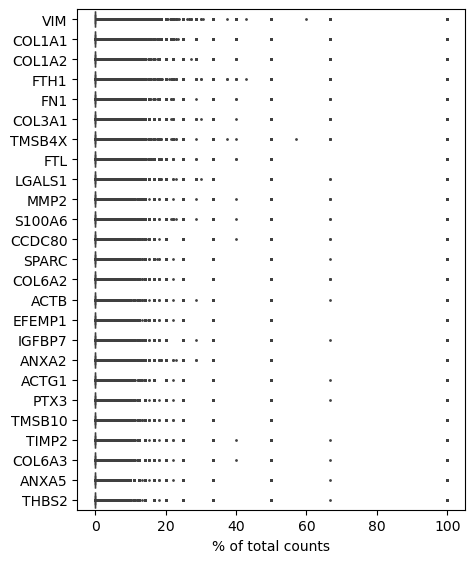

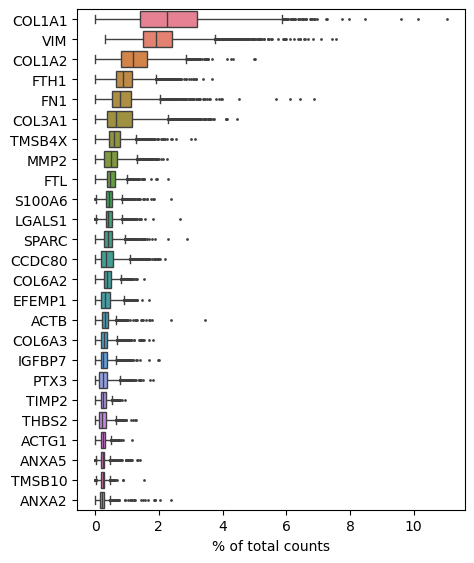

In [5]:
sc.pl.highest_expr_genes(adata, n_top=25, save=".raw.png")

## Capturing QC contol genes
In the next part, we add three (3) columns to the `adata` object to keep track of which genese are either mitochondrial, ribosomal, or hemoglobulal in nature. This makes it simple to filter (or select) out later on.

> Why do you think that we care about tracking these sets of genes?

In [5]:
adata.var['mt'] = adata.var_names.str.startswith('MT-')
adata.var['ribo'] = adata.var_names.str.startswith(('RPS', 'RPL'))

Below is an example of how we can now leverage these columns to select specific genes belonging to mitochondria.

In [6]:
adata.var[adata.var.mt == True]
adata.var[adata.var.ribo == True]

,gene_ids,feature_types,mt,ribo
RPL22,ENSG00000116251,Gene Expression,False,True
RPL11,ENSG00000142676,Gene Expression,False,True
RPS6KA1,ENSG00000117676,Gene Expression,False,True
RPS8,ENSG00000142937,Gene Expression,False,True
RPL5,ENSG00000122406,Gene Expression,False,True
...,...,...,...,...
RPL36A,ENSG00000241343,Gene Expression,False,True
RPL39,ENSG00000198918,Gene Expression,False,True
RPL10,ENSG00000147403,Gene Expression,False,True
RPS4Y1,ENSG00000129824,Gene Expression,False,True


In [9]:
adata

AnnData object with n_obs × n_vars = 1717953 × 37143
    obs: 'cell_type', 'batch', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo'
    var: 'gene_ids', 'feature_types', 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

### Calculating QC metrics

Instead of having to go through another round of FastQC, we can directly analyze the data withing the `scverse`. 

Once we have our selected genes identified, we can use them to quickly measure some quality metrics.


In [7]:
sc.pp.calculate_qc_metrics(
    adata, 
    qc_vars=['mt','ribo'],
    percent_top=None,
    log1p=False,
    inplace=True,
)

Let's do some "normalization" of the data. We can modify the columns to be percentages directly.

In [8]:
adata.obs.pct_counts_mt = adata.obs.pct_counts_mt/100
adata.obs.pct_counts_ribo = adata.obs.pct_counts_ribo/100

This gives us the metrics for:
1. Number of genes expressed
2. Total counts per cell
3. Percentage of Mitochondrial, ribosomal, and hemoglobular genes

If you remember from the presentation, these are the three good ways for early QC metrics.

#### Violin Plots
I am giving this bit of code as some may be unfamiliar with the violin plots.

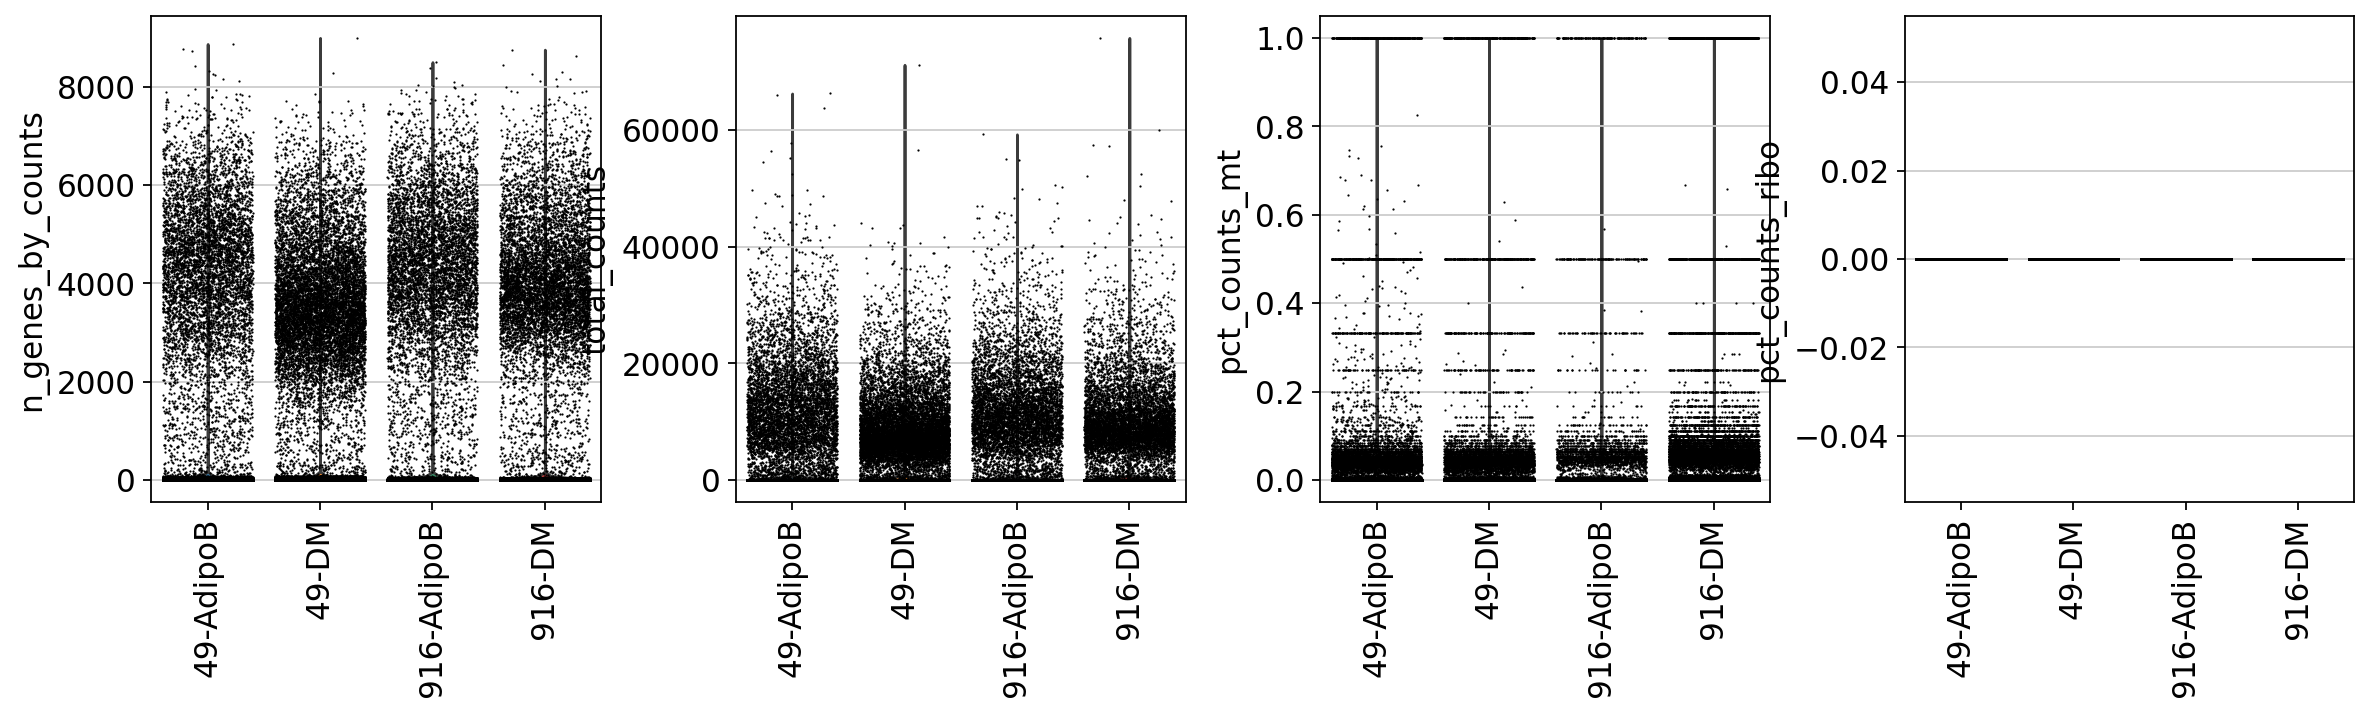

In [9]:
sc.pl.violin(adata,
             ['n_genes_by_counts',
              'total_counts',
              'pct_counts_mt',
              'pct_counts_ribo'],
             jitter = 0.4,
             groupby = 'cell_type',
             rotation=90,
             save = 'cell_type.png')

#### Scatter Plots

Plot the genes by data by number of genes by counts, % of mitochondrial gene counts, and % of ribosomal gene counts.

---
# Thresholding

## Overview
The plot below is fairly dense, but it gives us a high-level view of the data. By comparing total number of cells, total number of expressed genes, and scale it based on mitochondrial fraction, we can quickly see the overall quality of the data. While this plot is helpful for broad strokes, it doesn't have enough resolution to isolate the granular thresholds.

Using the foundation of the scatterplot above, generate a scatter plot that uses just the total counts less than 8000, and plot by total counts and number of genes by counts.

Bonus points if you can manipulate the color of the scatter plot based on one of our QC metrics.

Lastly, add some lines to the horizontal and vertical axes at 500 and 1000, respectively.

In [26]:
cell_types = adata.obs.cell_type.unique()

for cell_type in cell_types:
    fig, ax = plt.subplots(figsize=(8, 8))
    
    cell_data = adata[adata.obs.cell_type == cell_type]
    
    sc.pl.scatter(
        cell_data,
        'total_counts', 
        'n_genes_by_counts',
        color='pct_counts_mt',
        size=20,
        title=f'{cell_type} - pct_counts_mt',
        ax=ax,
        show=False
    )
    
    ax.axhline(500, color='red', linestyle=':')
    ax.axvline(1000, color='red', linestyle=':')
    
    plt.tight_layout()
    plt.savefig(f"figures/scatter_plot_{cell_type}.png", dpi=80, bbox_inches='tight')
    plt.close()


/tmp/ipykernel_30418/2872318464.py:22: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/tmp/ipykernel_30418/2872318464.py:22: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/tmp/ipykernel_30418/2872318464.py:22: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/tmp/ipykernel_30418/2872318464.py:22: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


In [ ]:
max(adata.obs.pct_counts_mt)

> By looking at plots of the number of genes versus the number of counts with MT fraction information, we can assess whether there are cells with unexpected summary statistics. It is important here to look at these statistics jointly. 

> We should filter out some cells with very few genes as these may be difficult to annotate later. This will be true for the initial cellular density between 1000-4000 counts and < ~500 genes.

> Furthermore it can be seen in the main cloud of data points, that cells with lower counts and genes tend to have a higher fraction of mitochondrial counts. These cells are likely under stress or are dying. When apoptotic cells are sequenced, there is less mRNA to be captured in the nucleus, and therefore fewer counts overall, and thus a higher fraction of counts fall upon mitochondrial RNA. If cells with high mitochondrial activity were found at higher counts/genes per cell, this would indicate biologically relevant mitochondrial activity.

-[CZ-BioHub](https://github.com/theislab/scanpy-demo-czbiohub/blob/master/10X_PBMC.ipynb)


## Number of UMIs (or cells)

For any given UMI, we hope to see higher UMI counts if and only if it is a living cell or multiplet. We also want to know where to set the low count UMI threshold so that we can quickly filter out droplets with dead or dying cells and ambient RNA.

You will see that we will continue to explore these values using histograms or kernel density estimate plots. There are many types of plotting packages out there and pretty much no two tutorials or walkthroughs use the same approach. Part of this is due to the aesthetics involved in these plots. People like, want, or prefer particular kinds of visuals. Some people may just rely on the plots defined by `scanpy` or something more stylized by `seaborn` or want full control using `matplotlib`. The good news is that all these plotting approaches build off of each other and can be used somewhat interchangeably (as you will see). This is something very similar to `ggplot` in which you can think of layers of paint being applied to each other to create a complete painting.

> **DISCLAIMER**: this tutorial uses a very small subset of a much larger experiment. As such, instead of working with 10's of thousands of cells and their reads, we are only dealing with three thousand (3k). Keep that in mind as we continue this analysis and try to extrapolate how that will impact the analysis of our class dataset.

Below you will the code that mixes `matplotlib` and `seaborn` (`sns`) plotting elements to control for the aesthetics of the plot

In [ ]:
mpl.rcParams['figure.figsize']=(20,5)
fig, axes = plt.subplots(1,3)
fig.subplots_adjust(hspace=0.4, wspace=0.3)

sns.histplot(adata.obs['total_counts'], 
                 kde=False, ax=axes[0])
sns.histplot(adata.obs['total_counts'][adata.obs['total_counts']<2000], 
                 kde=False, bins=60, ax=axes[1])
axes[1].axvline(825, color='red', linestyle=':')
sns.histplot(adata.obs['total_counts'][adata.obs['total_counts']>6000], 
                 kde=False, bins=60, ax=axes[2])
plt.savefig("figures/total_counts.hist.filtered.png")
fig.show()
plt.rcdefaults()


mpl.rcParams['figure.figsize']=(20,5)
fig, axes = plt.subplots(1,3)
fig.subplots_adjust(hspace=0.4, wspace=0.3)

sns.histplot(adata_raw.obs['total_counts'], 
                 kde=False, ax=axes[0])
sns.histplot(adata_raw.obs['total_counts'][adata_raw.obs['total_counts']<2000], 
                 kde=False, bins=60, ax=axes[1])
axes[1].axvline(825, color='red', linestyle=':')
sns.histplot(adata_raw.obs['total_counts'][adata_raw.obs['total_counts']>6000], 
                 kde=False, bins=60, ax=axes[2])
plt.savefig("figures/total_counts.hist.raw.png")
fig.show()
plt.rcdefaults()

#### Kernel Density Estimate (KDE) Plot
KDEs are good for looking at the population distribution of a bunch of data. Think of it as plotting the heights of all gold medal atheletes.

In [ ]:
adata_raw.obs['total_counts']

In [ ]:
density = sns.kdeplot(adata.obs['total_counts'], shade=True, log_scale=True)
density.xaxis.set_major_formatter(mpl.ticker.ScalarFormatter())
plt.axvline(825, color='red', linestyle=':')
plt.savefig("figures/total_counts.kdeplot.filtered.png")
plt.show()

density = sns.kdeplot(adata_raw.obs['total_counts'], shade=True, log_scale=True)
density.xaxis.set_major_formatter(mpl.ticker.ScalarFormatter())
plt.axvline(825, color='red', linestyle=':')
plt.savefig("figures/total_counts.kdeplot.raw.png")
plt.show()

> **Question**: Given the samples plots above, what would you set the threshold to for filtering the low (or high) count UMIs?

<details>
    <summary>Click to see my analysis</summary>
    Histograms of the number of counts per cell show a small peak of groups of cells with fewer than **825 counts**, which are likely uninformative given the overall distribution of counts. This may be cellular debris found in droplets.

On the upper end of counts, we see a population of cells with high counts with decaying slope at 4,000 counts. However, we are going to be less conservative on filtering the higher end.
</details>

> **Question**: Do you agree with my threshold? Why or why not?

## Number of genes
Much like the UMIs above, we want to filter out cells that don't express many genes because that is indicative of a dead/dying/missing cell within the droplet. We have to identify our interpretation of this threshold and we do that in the same way as above.

> Reconfigure the previous plots, but for number of genes by counts: total and ones with fewer than 1000 genes.

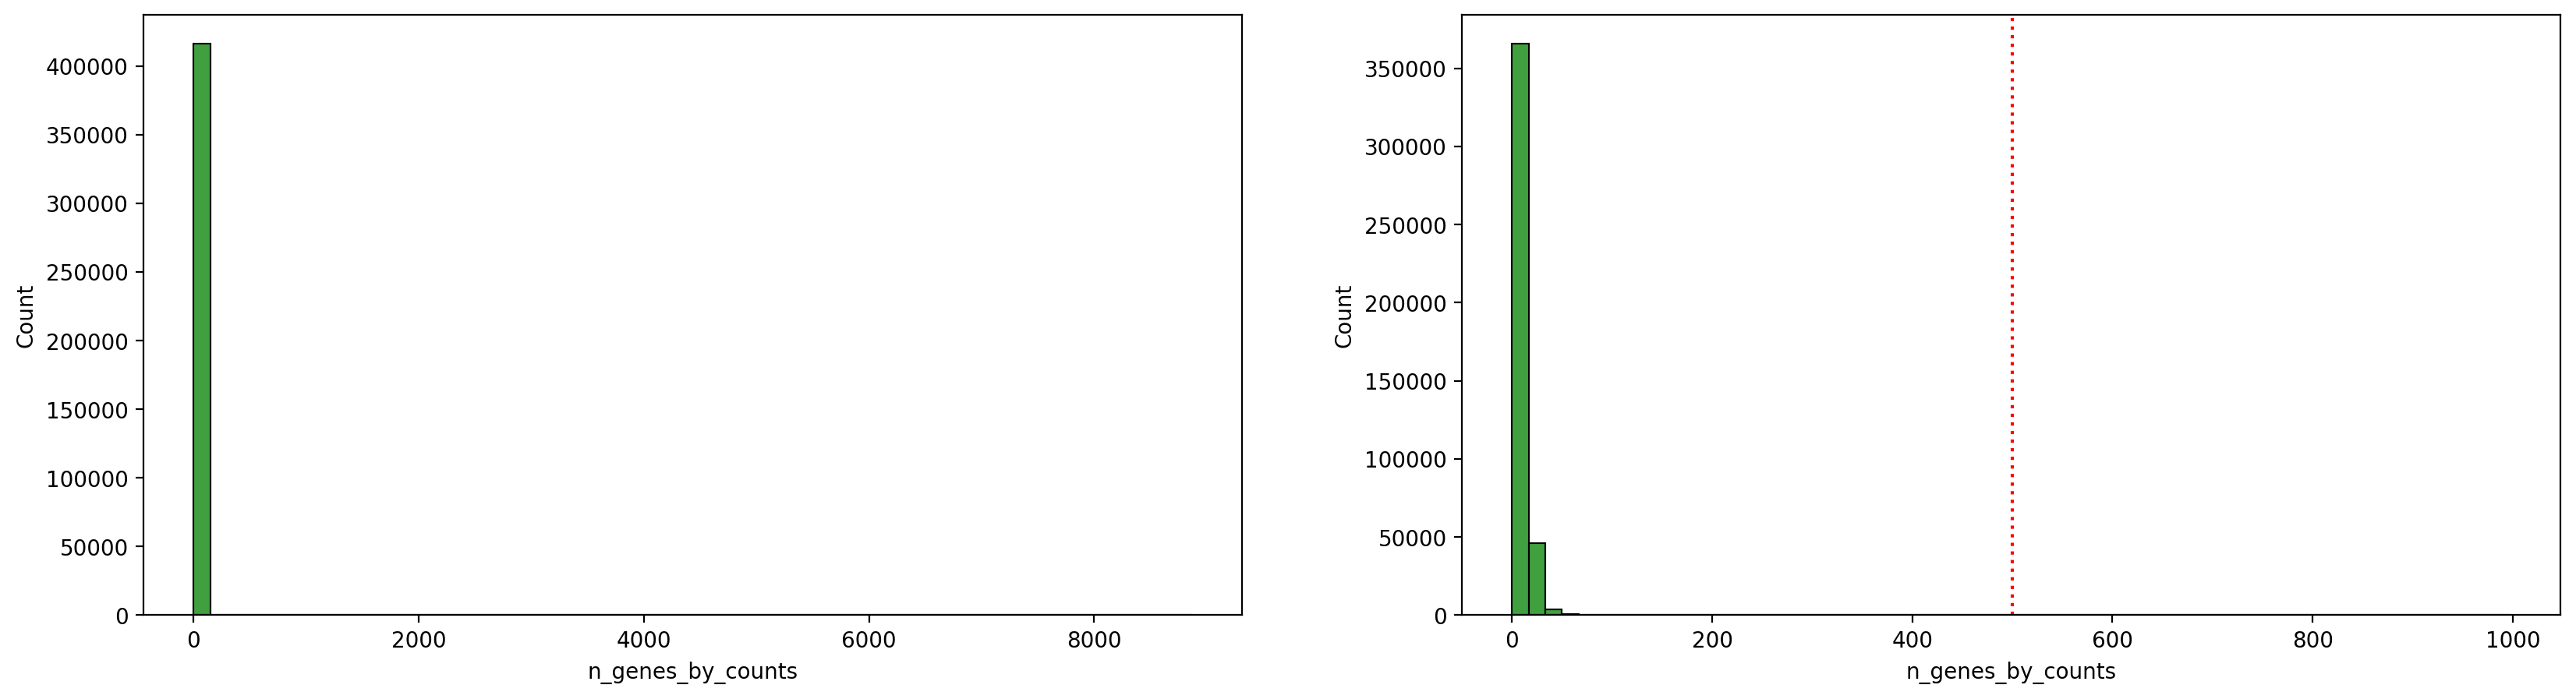

/home/wlodychak.s/micromamba/envs/scanpy/lib/python3.12/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
/tmp/ipykernel_30418/1452923885.py:19: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  density = sns.kdeplot(cell_data.obs['n_genes_by_counts'], shade=True, log_scale=True, color='green')


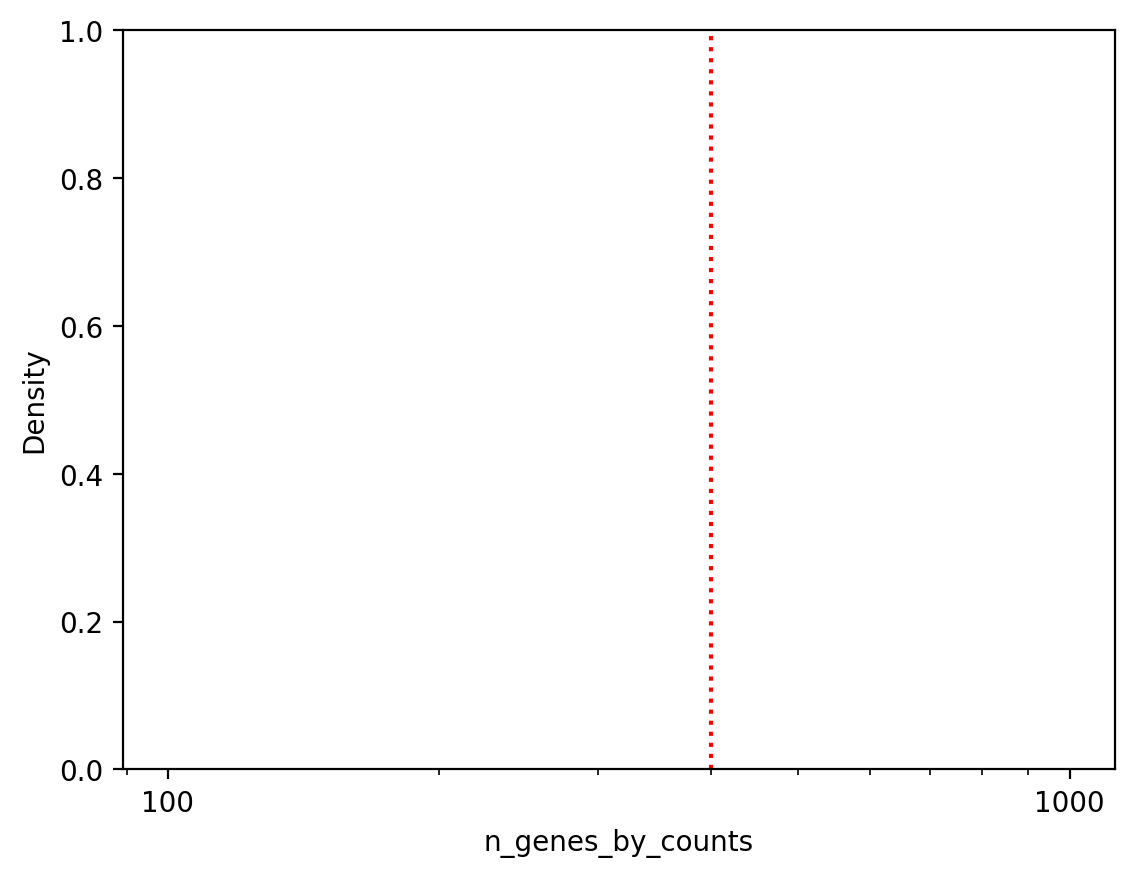

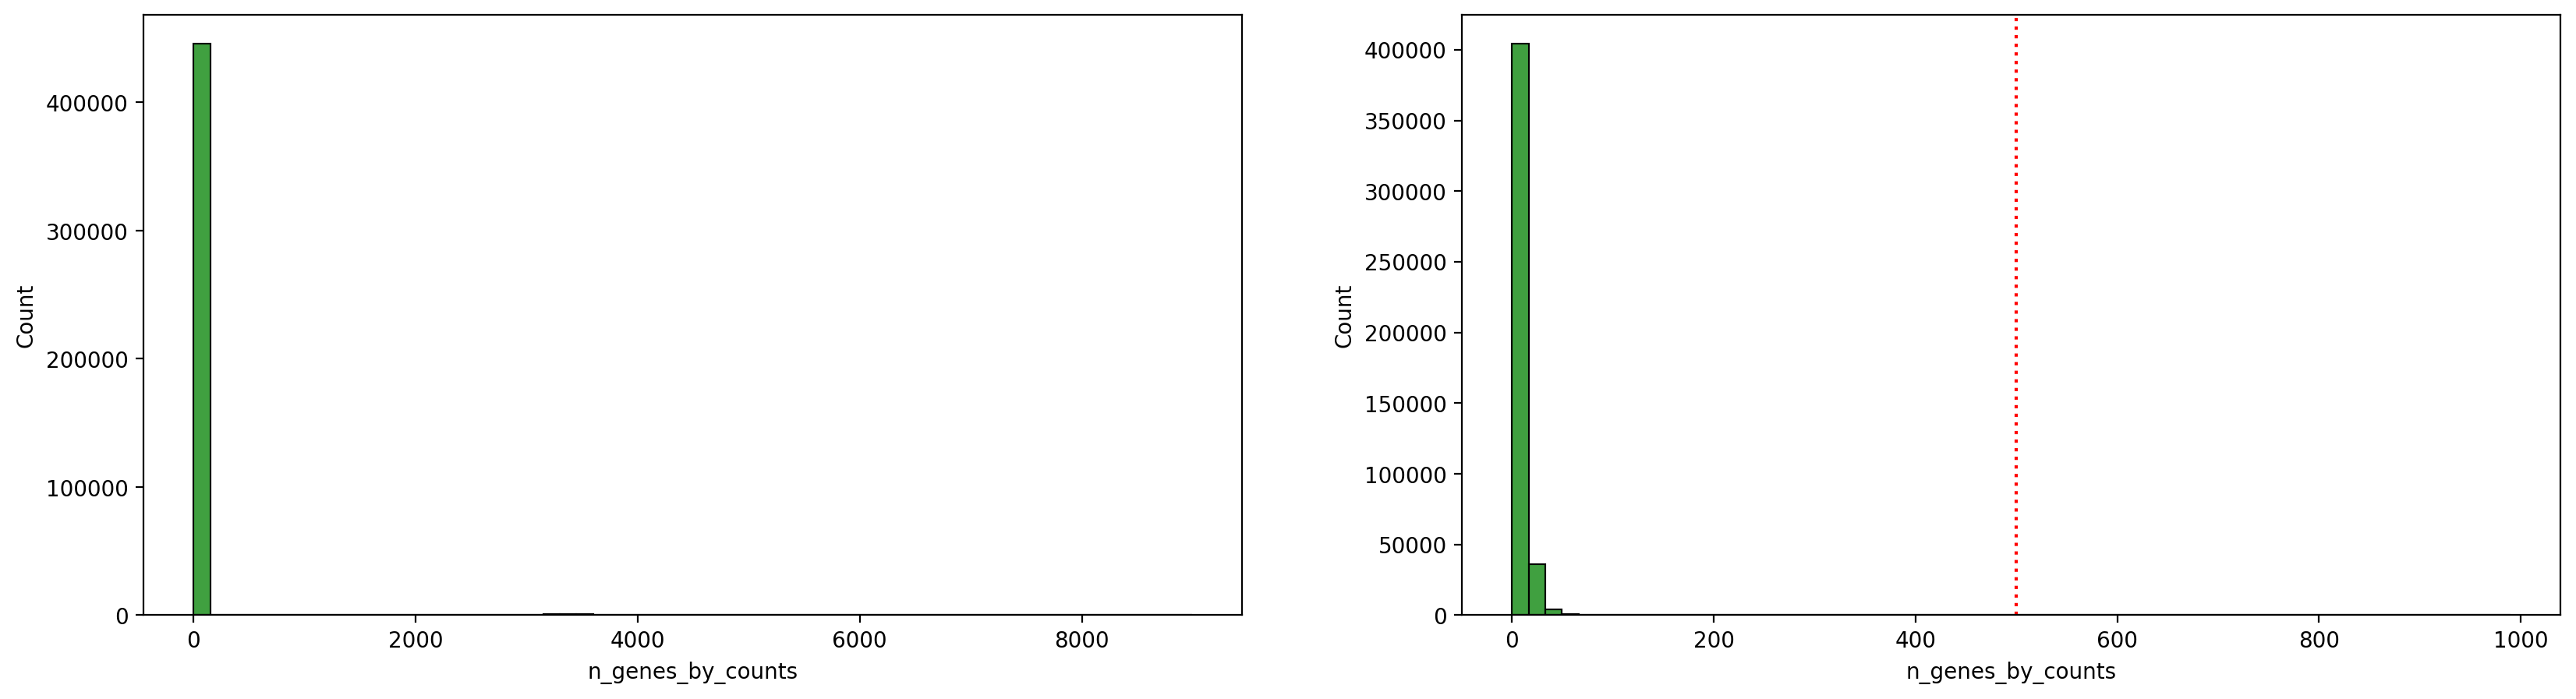

/home/wlodychak.s/micromamba/envs/scanpy/lib/python3.12/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
/tmp/ipykernel_30418/1452923885.py:19: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  density = sns.kdeplot(cell_data.obs['n_genes_by_counts'], shade=True, log_scale=True, color='green')


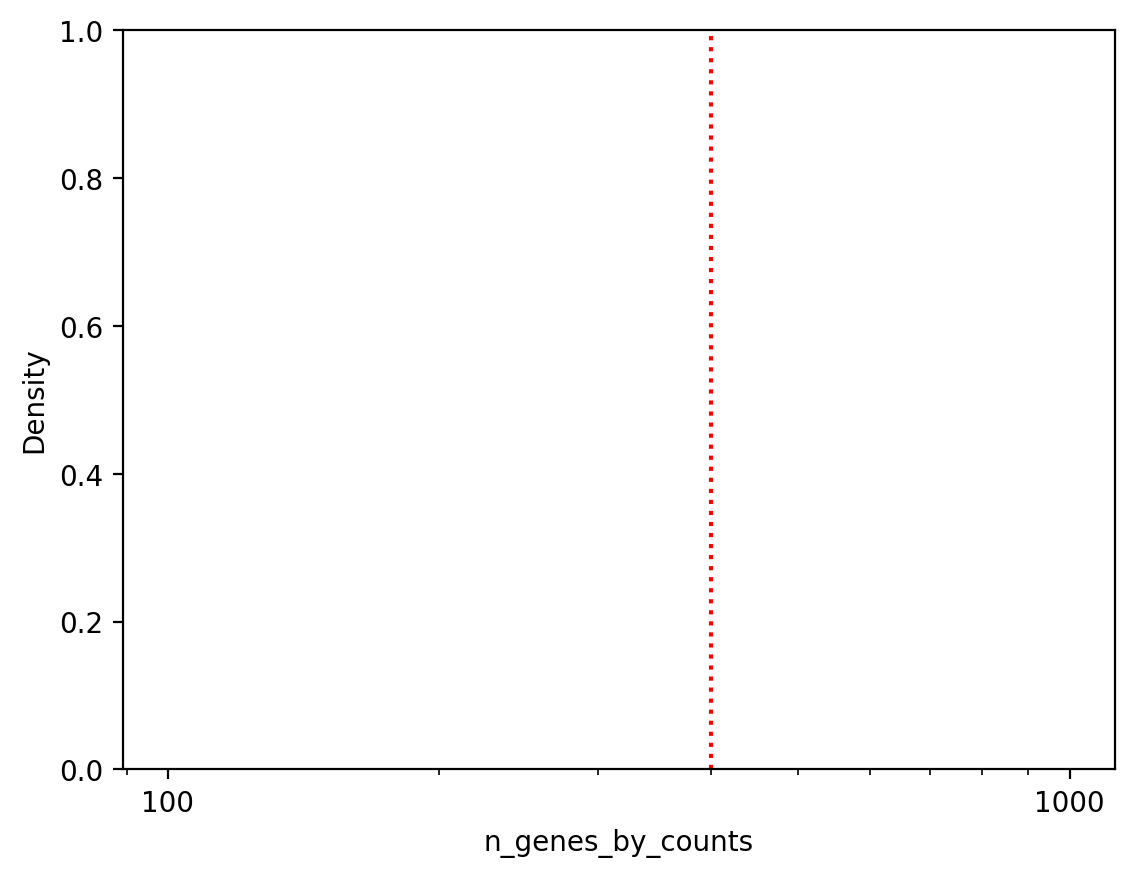

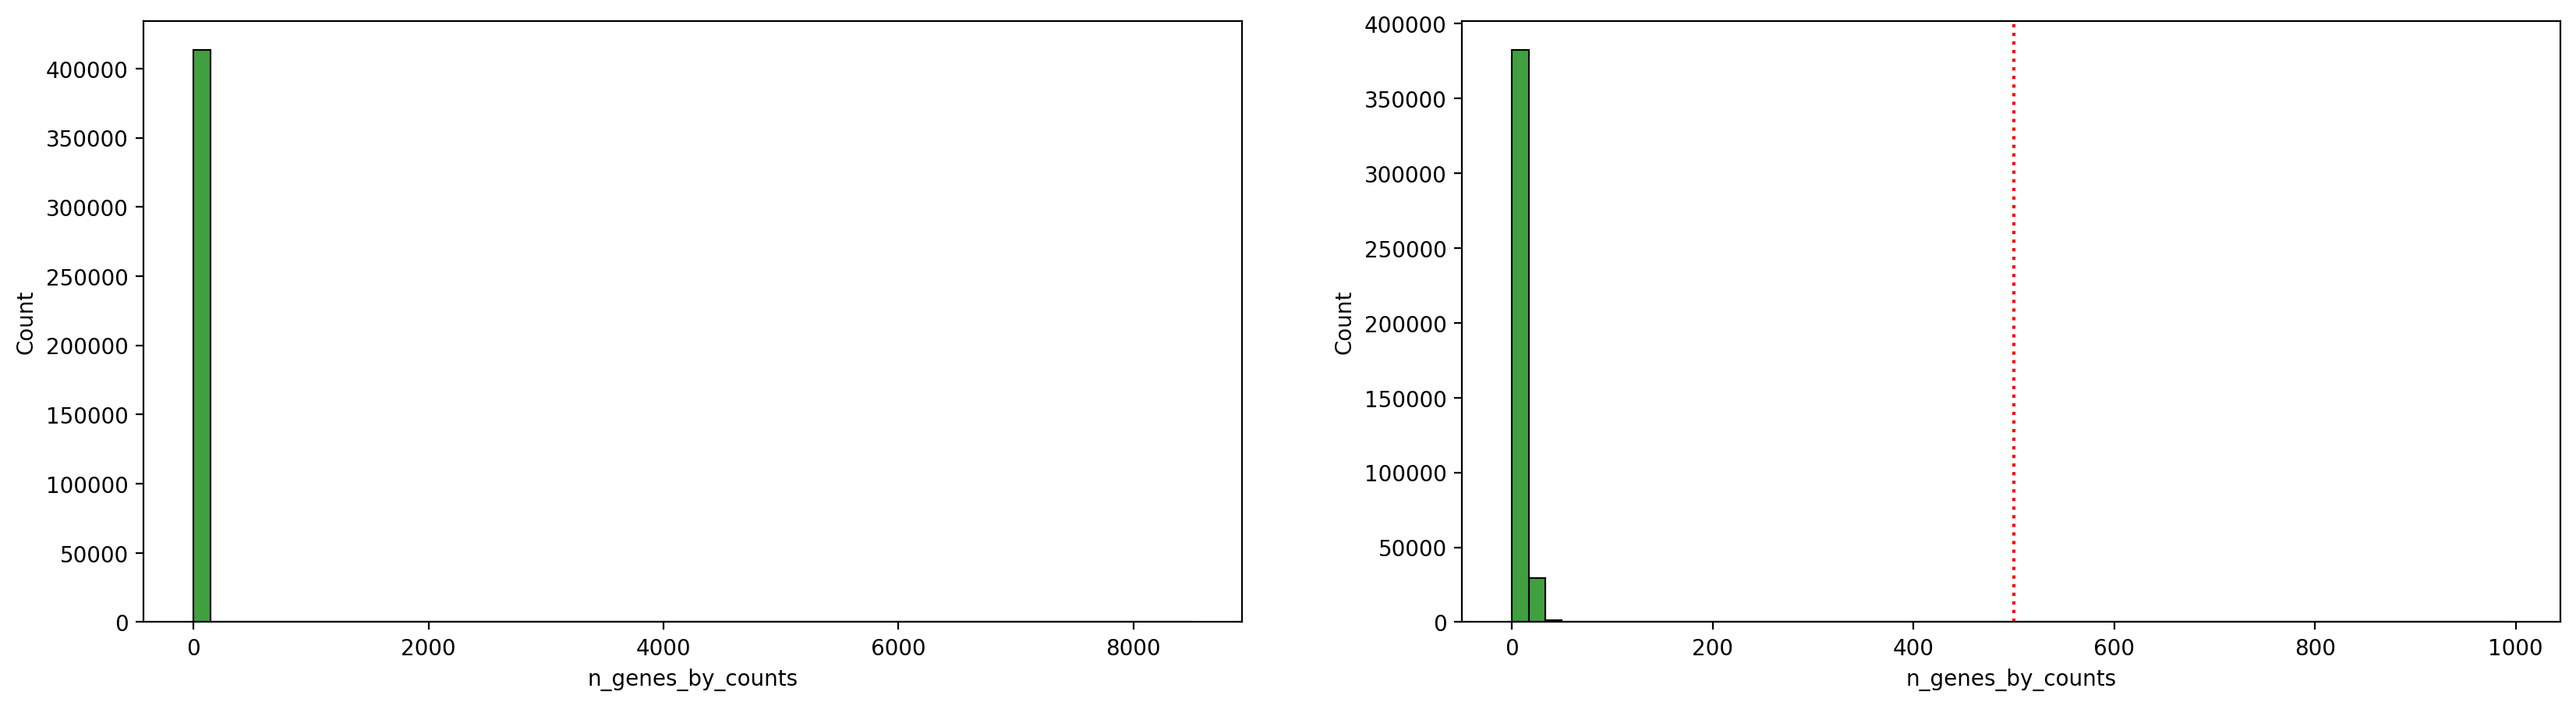

/home/wlodychak.s/micromamba/envs/scanpy/lib/python3.12/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
/tmp/ipykernel_30418/1452923885.py:19: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  density = sns.kdeplot(cell_data.obs['n_genes_by_counts'], shade=True, log_scale=True, color='green')


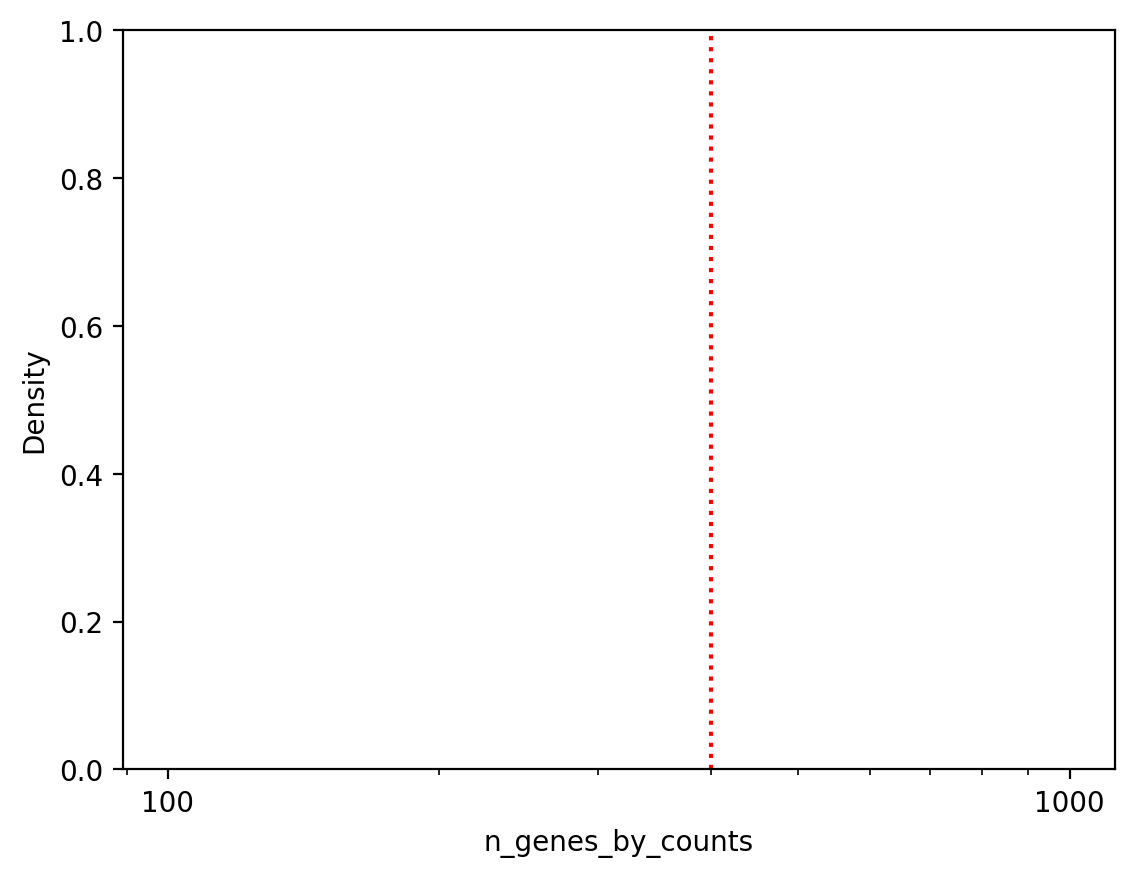

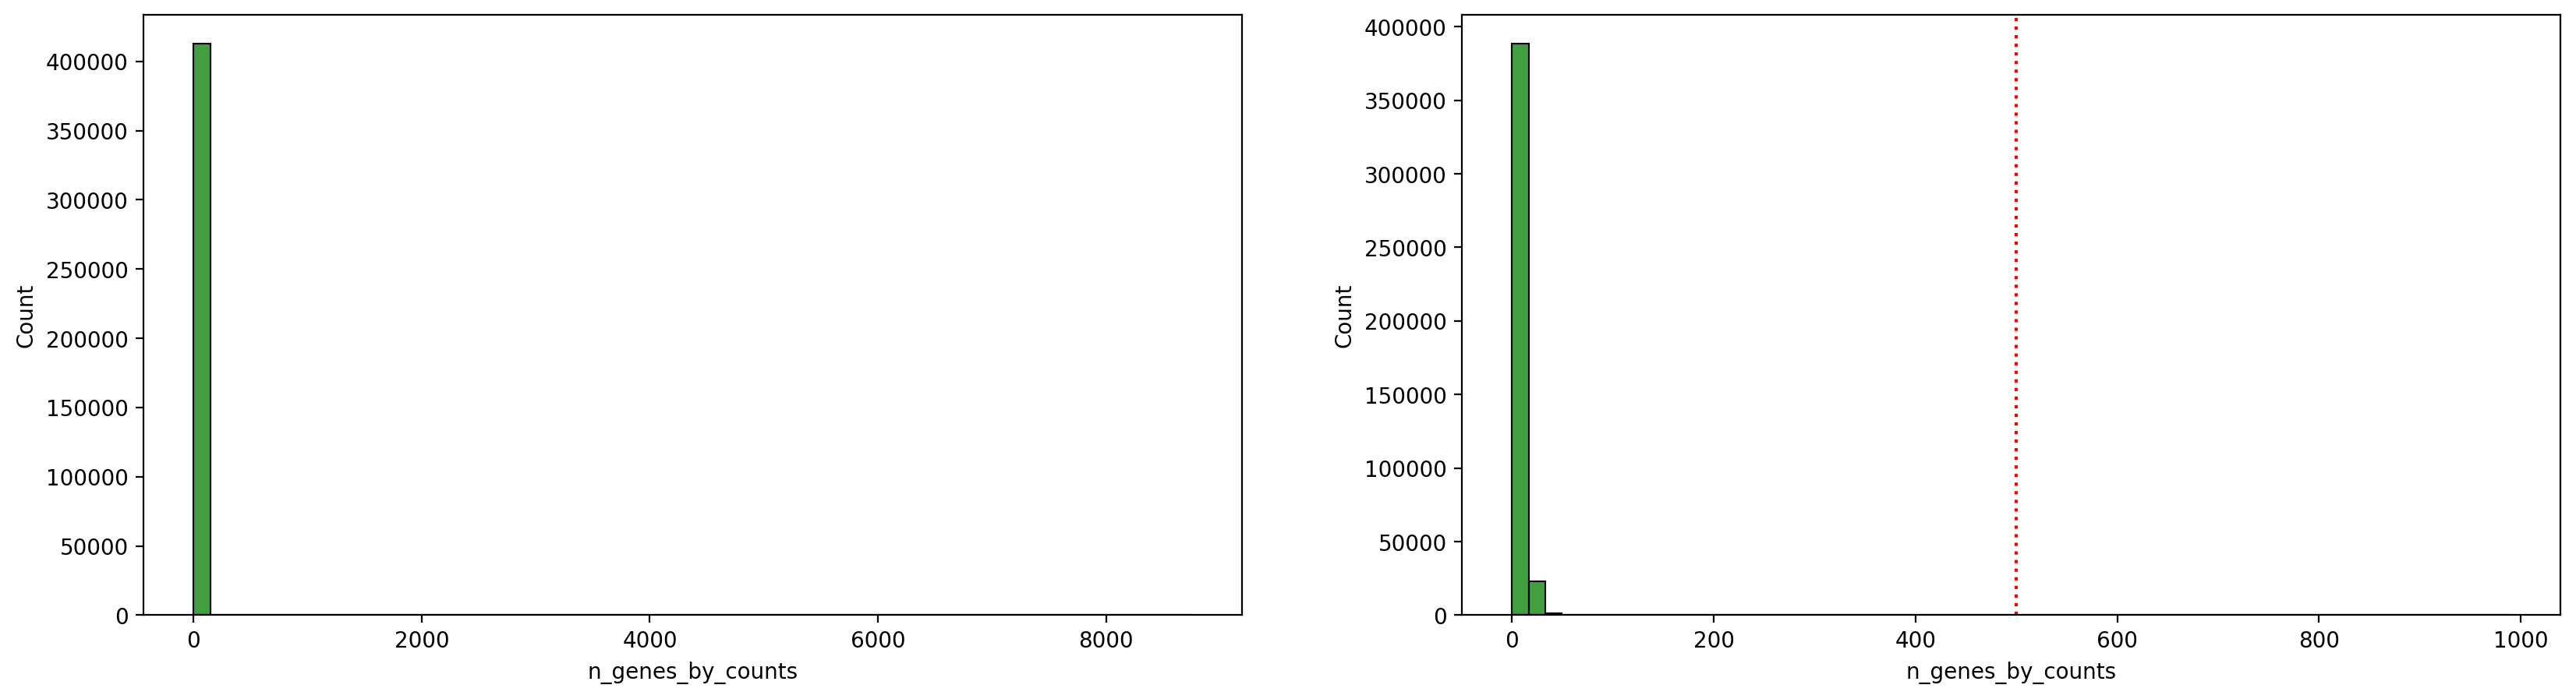

/home/wlodychak.s/micromamba/envs/scanpy/lib/python3.12/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
/tmp/ipykernel_30418/1452923885.py:19: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  density = sns.kdeplot(cell_data.obs['n_genes_by_counts'], shade=True, log_scale=True, color='green')


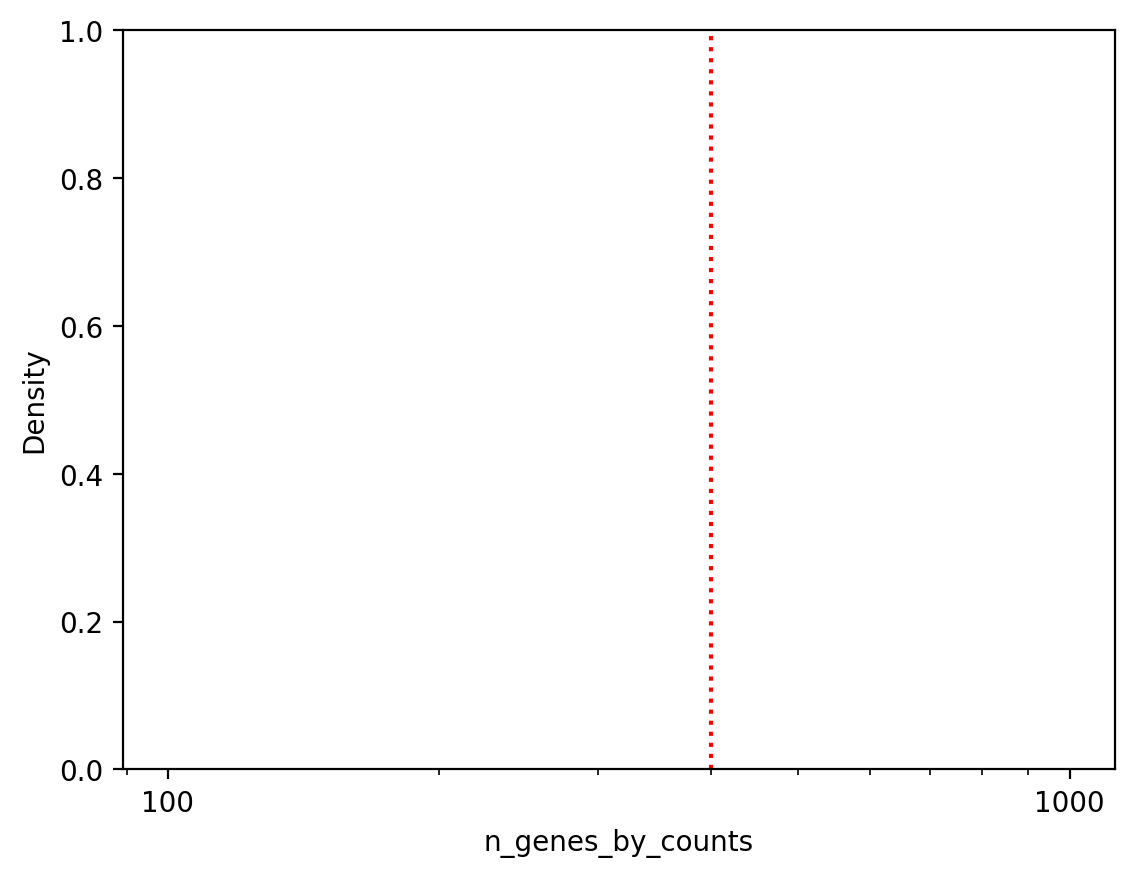

In [28]:
cell_types = adata.obs.cell_type.unique()

for cell_type in cell_types:
    cell_data = adata[adata.obs.cell_type == cell_type]
    mpl.rcParams['figure.figsize']=(20,5)
    fig, axes = plt.subplots(1,2)
    fig.subplots_adjust(hspace=0.4, wspace=0.2)

    sns.histplot(cell_data.obs.n_genes_by_counts, kde=False, bins=60, ax=axes[0], color='green')

    sns.histplot(cell_data.obs.n_genes_by_counts[cell_data.obs.n_genes_by_counts < 1000], 
                     kde=False, bins=60, ax=axes[1], color='green')
    axes[1].axvline(500, color='red', linestyle=':')
    plt.savefig(f"figures/n_genes_by_counts.hist.{cell_type}.png")
    plt.show()
    plt.rcdefaults()
    plt.close()
    
    density = sns.kdeplot(cell_data.obs['n_genes_by_counts'], shade=True, log_scale=True, color='green')
    density.xaxis.set_major_formatter(mpl.ticker.ScalarFormatter())
    plt.axvline(400, color='red', linestyle=':')
    plt.savefig(f"figures/n_genes_by_counts.density.{cell_type}.png")
    plt.show()
    plt.close()

> **Question**: Just like the last section, what you would set as a threshold for minimum number of genes a cell must express?

<details>
    <summary>Click to see my analysis</summary>
Given these plots, and the plot of genes vs counts above, we decide to filter out cells with fewer than **500 genes** expressed. Below this we are likely to find dying cells or empty droplets with ambient RNA. Looking above at the joint plots, we see that we filter out the main density of low gene cells with this threshold.

In general it is a good idea to be permissive in the early filtering steps, and then come back to filter out more stringently when a clear picture is available of what would be filtered out. This is available after visualization/clustering. For demonstration purposes we stick to a simple (and slightly more stringent) filtering here.
</details>

> **Question**: Do you agree with my threshold? Why or why not?

## Mitochondiral and ribosomal gene ratio
We also want to filter out cells that have high mitochondrial gene expression ratios. In the event of a dead/dying/missing cell in the droplet, mitochondrial genes appear to be overexpressed since they are less likely to be degraded in a cell with a perforated nucleus. In a similar manner, this also applies to ribosomal genes. We can set those thresholds as well.

> This section of code is provided simply because it is a regurgitation of the previous plots, just with the mitochondrial and ribosomal genes instead. The question that I want you to ask yourself here is **"WHY DO I CARE ABOUT MITOCHONDRIAL AND RIBOSOMAL GENE COUNTS?"**

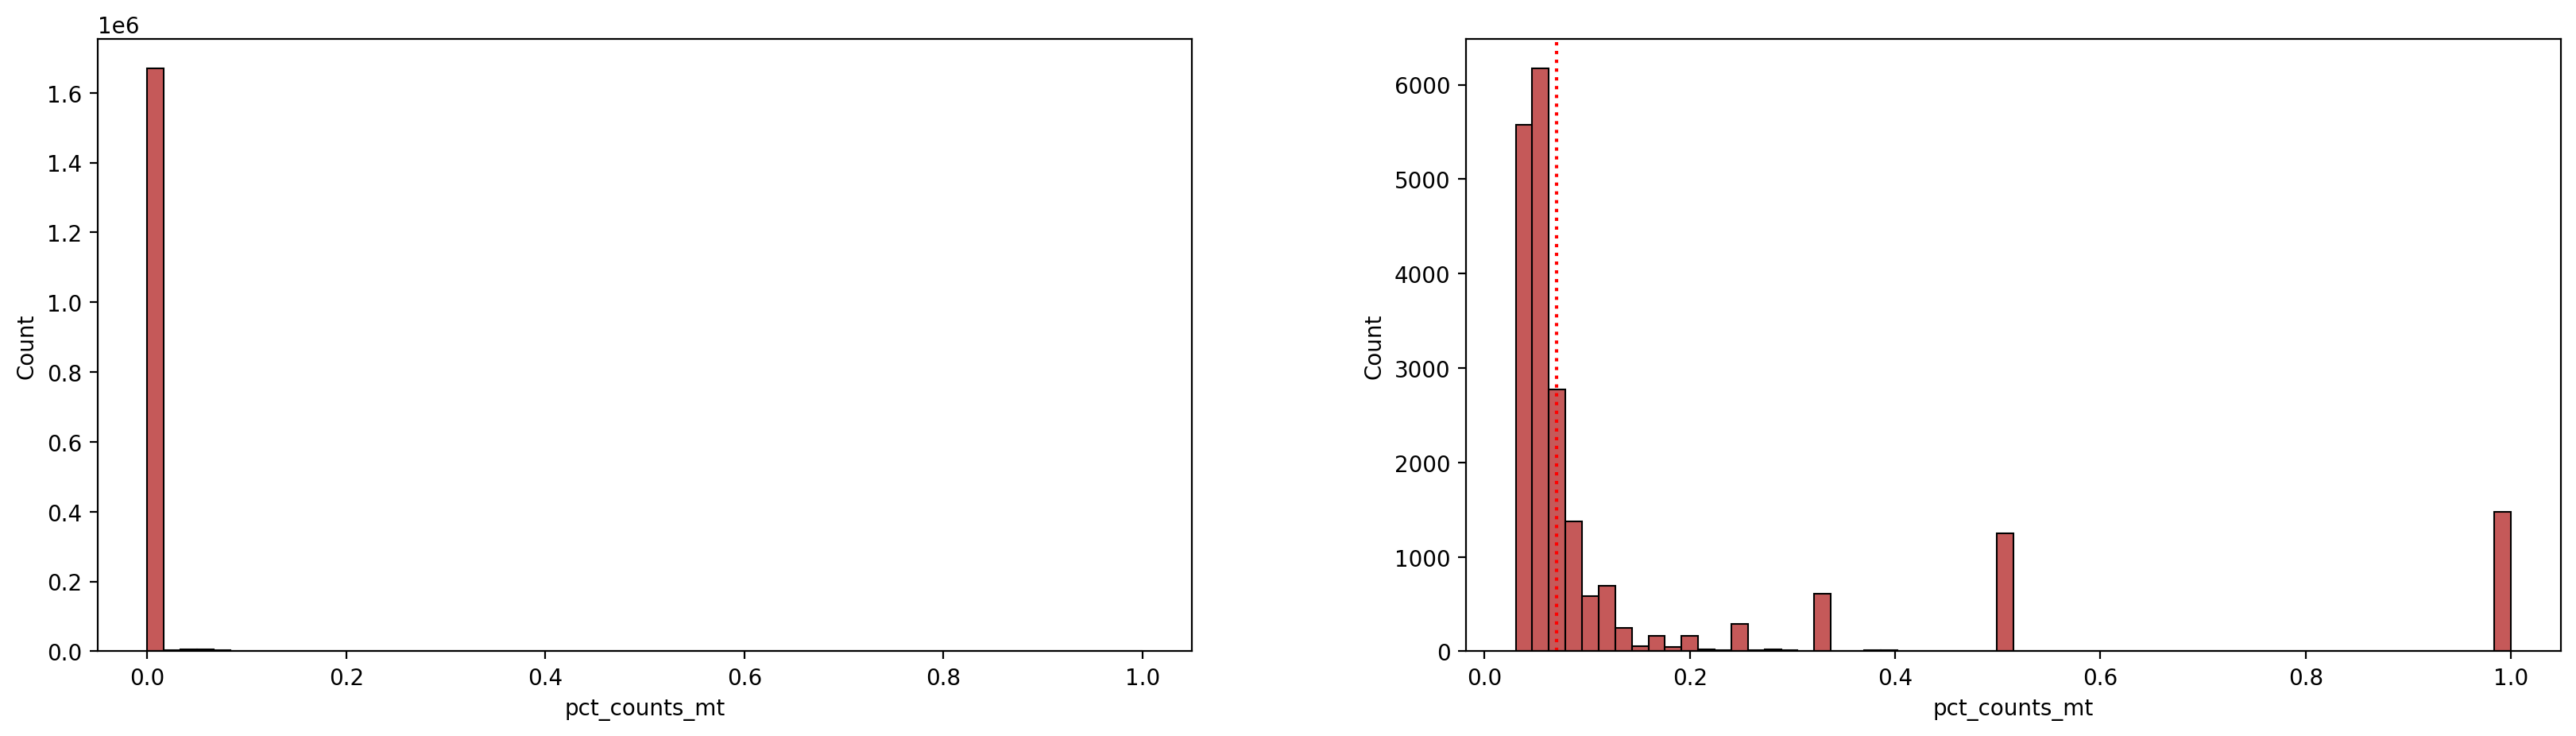

In [38]:
mpl.rcParams['figure.figsize']=(20,5)
fig, axes = plt.subplots(1,2)
fig.subplots_adjust(hspace=0.4, wspace=0.25)

sns.histplot(adata.obs.pct_counts_mt, kde=False, bins=60, ax=axes[0], color='firebrick')

sns.histplot(adata.obs.pct_counts_mt[adata.obs.pct_counts_mt > .030], 
                 kde=False, bins=60, ax=axes[1], color='firebrick')
axes[1].axvline(0.07, color='red', linestyle=':')
plt.savefig("figures/mt.hist.raw.png")
plt.show()
plt.rcdefaults()

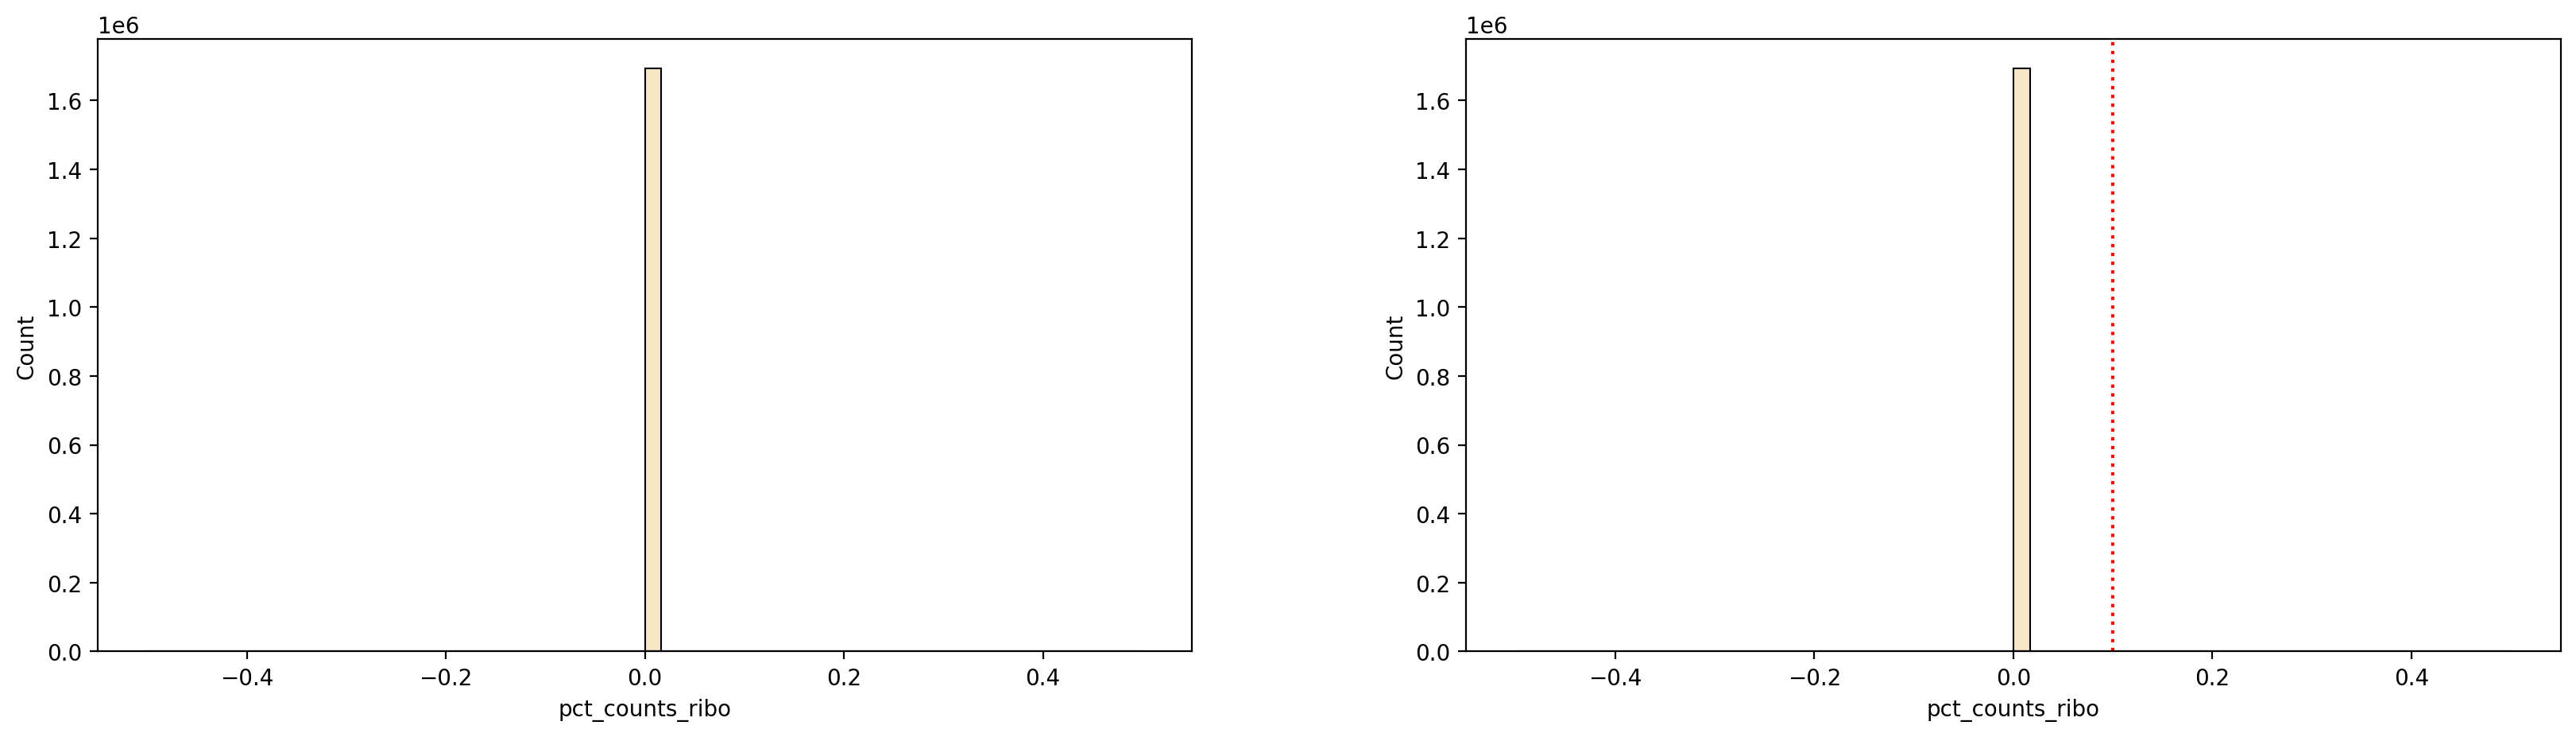

In [36]:
## Raw matrix
mpl.rcParams['figure.figsize']=(20,5)
fig, axes = plt.subplots(1,2)
fig.subplots_adjust(hspace=0.4, wspace=0.25)

sns.histplot(adata.obs.pct_counts_ribo, kde=False, bins=60, ax=axes[0], color='wheat')

sns.histplot(adata.obs.pct_counts_ribo[adata.obs.pct_counts_ribo < .2], 
                 kde=False, bins=60, ax=axes[1], color='wheat')
axes[1].axvline(0.1, color='red', linestyle=':')
plt.savefig("figures/ribo.hist.raw.png")
plt.show()
plt.rcdefaults()

In [ ]:
density = sns.kdeplot(adata.obs.pct_counts_ribo, shade=True, color='wheat')
density.xaxis.set_major_formatter(mpl.ticker.ScalarFormatter())
plt.axvline(0.1, color='red', linestyle=':')
plt.show()

> **Question**: What you would set as a threshold for the maximum mitochondrial genes ratio and the minimum number of ribosomal genes ratio?

<details>
    <summary>Click to see my analysis</summary>
Given these plots I would choose maximum mitochondrial genes ratio to be **7.5%** and minimum ribosomal gene ratio to be 10%
</details>

> **Question**: Do you agree with my threshold? Why or why not?

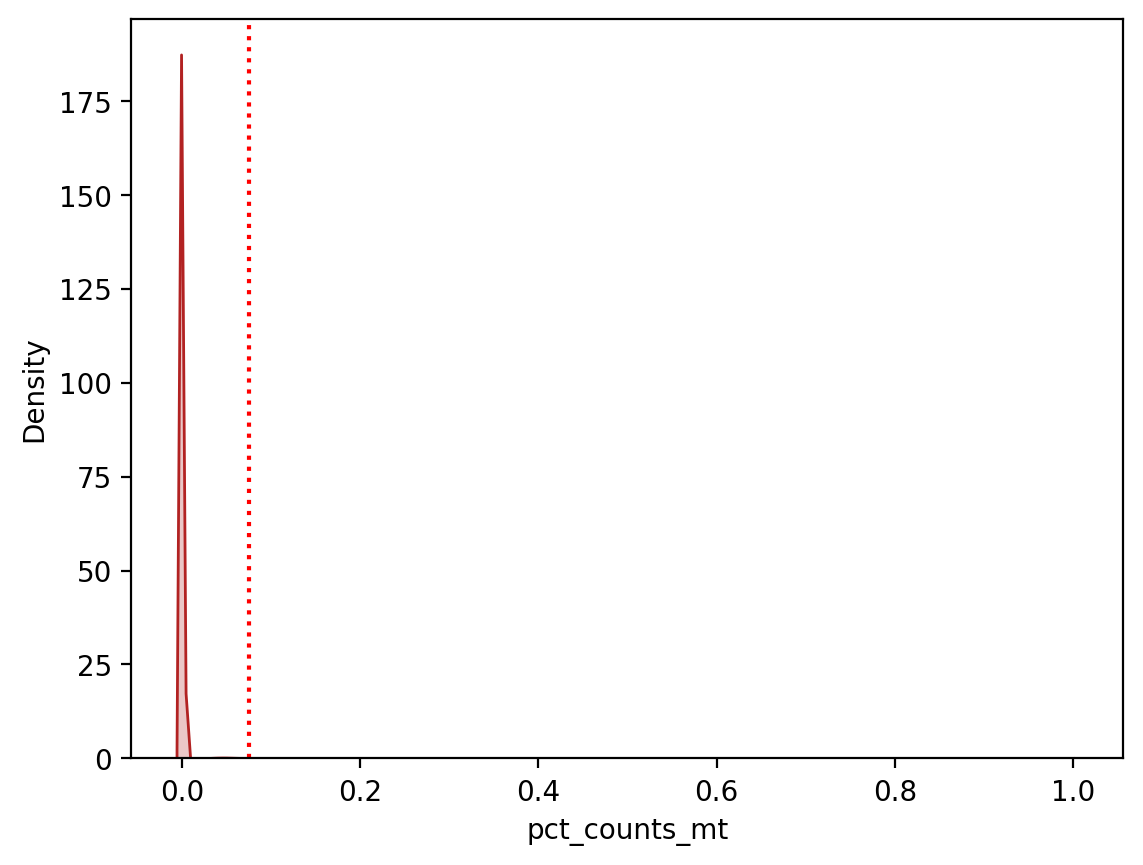

In [39]:
density = sns.kdeplot(adata.obs.pct_counts_mt, shade=True, color='firebrick')
density.xaxis.set_major_formatter(mpl.ticker.ScalarFormatter())
plt.axvline(0.075, color='red', linestyle=':')
plt.savefig("figures/mt.density.filtered.png")
plt.show()

## Cells per gene

Lastly, we need to determine how many cells a gene has to be expressed in for it to meet a threshold. If we filter out genes that are either not expressed in any cells or are only expressed in a few, we reduce the complexity of our downstream analysis signficantly. The determine that number, we look at yet another plot.

The task here is to generate a histogram and KDE plot of the number of cells by counts for just the data that is between 1 and 50. This is where I will introduce you to the `.between()` method in AnnData objects. Use this to index/select these specific cells. 

In [33]:
cell_types = adata.obs.cell_type.unique()

for cell_type in cell_types:
    # Clear any existing plots
    plt.clf()
    
    # Create figure for histogram
    plt.figure(figsize=(10, 6))
    cell_data = adata[adata.obs.cell_type == cell_type]
    gbc = sns.histplot(cell_data.var.n_cells_by_counts[cell_data.var.n_cells_by_counts.between(1,50)], 
                       color='darkgrey', bins=20, log_scale=True)
    gbc.xaxis.set_major_formatter(mpl.ticker.ScalarFormatter())
    plt.axvline(5, color='red', linestyle=':')
    plt.title(f'{cell_type} - n_cell_counts')
    plt.savefig(f"figures/n_cells_by_counts.hist.{cell_type}.png")
    plt.close()

    # Create new figure for KDE plot
    plt.figure(figsize=(10, 6))
    gbc2 = sns.kdeplot(cell_data.var.n_cells_by_counts[cell_data.var.n_cells_by_counts.between(1,50)], 
                       color='darkgrey', fill=True, log_scale=True)  # Note: 'shade' is deprecated, use 'fill'
    gbc2.xaxis.set_major_formatter(mpl.ticker.ScalarFormatter())
    plt.axvline(5, color='red', linestyle=':')
    plt.title(f'{cell_type} - n_cell_counts')
    plt.savefig(f"figures/n_cells_by_counts.kde.{cell_type}.png")
    plt.close()


<Figure size 640x480 with 0 Axes>

> **Question**: What would have selected for the minimum cells per gene threshold?

<details>
    <summary>Click to see my analysis</summary>
Given these plots, especially the kernel density estimate, it appear that the threshold of genes being expressed in **5** cells or more to be valid genes to retain while still reducing dimensionality reduction.
</details>

> **Question**: Do you agree with my threshold? Why or why not?

## Summary of thresholding
<details>
    <summary>Click to see final thresholds</summary>
Our thresholds for this data are as follows:
    
1. Minimum total counts: 825
2. Minimum genes: 500
3. Maximum Mitochondrial fraction: 7.5%
4. Minimum Ribosomal fraction: 10 %
5. Cells per gene: 5
</details></br>

**Fun Fact**: `scanpy` has a special module just for using pre-baked thresholding that are used as a basic default or "best practice" threshold depending on the workflow. The one that is probably used the most is `sc.pp.recipe_seurat` which uses:
1. Min genes: 200
2. Min cells: 3
3. Filters on some gene dispersions

# Filtering

Using our thresholds above, let's filter the data.

In [ ]:
adata.obs.columns
adata.var.columns


sc.pl.violin(adata_raw, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt', 'pct_counts_ribo'], 
             jitter=0.4, multi_panel=True, save="raw.violin.png")


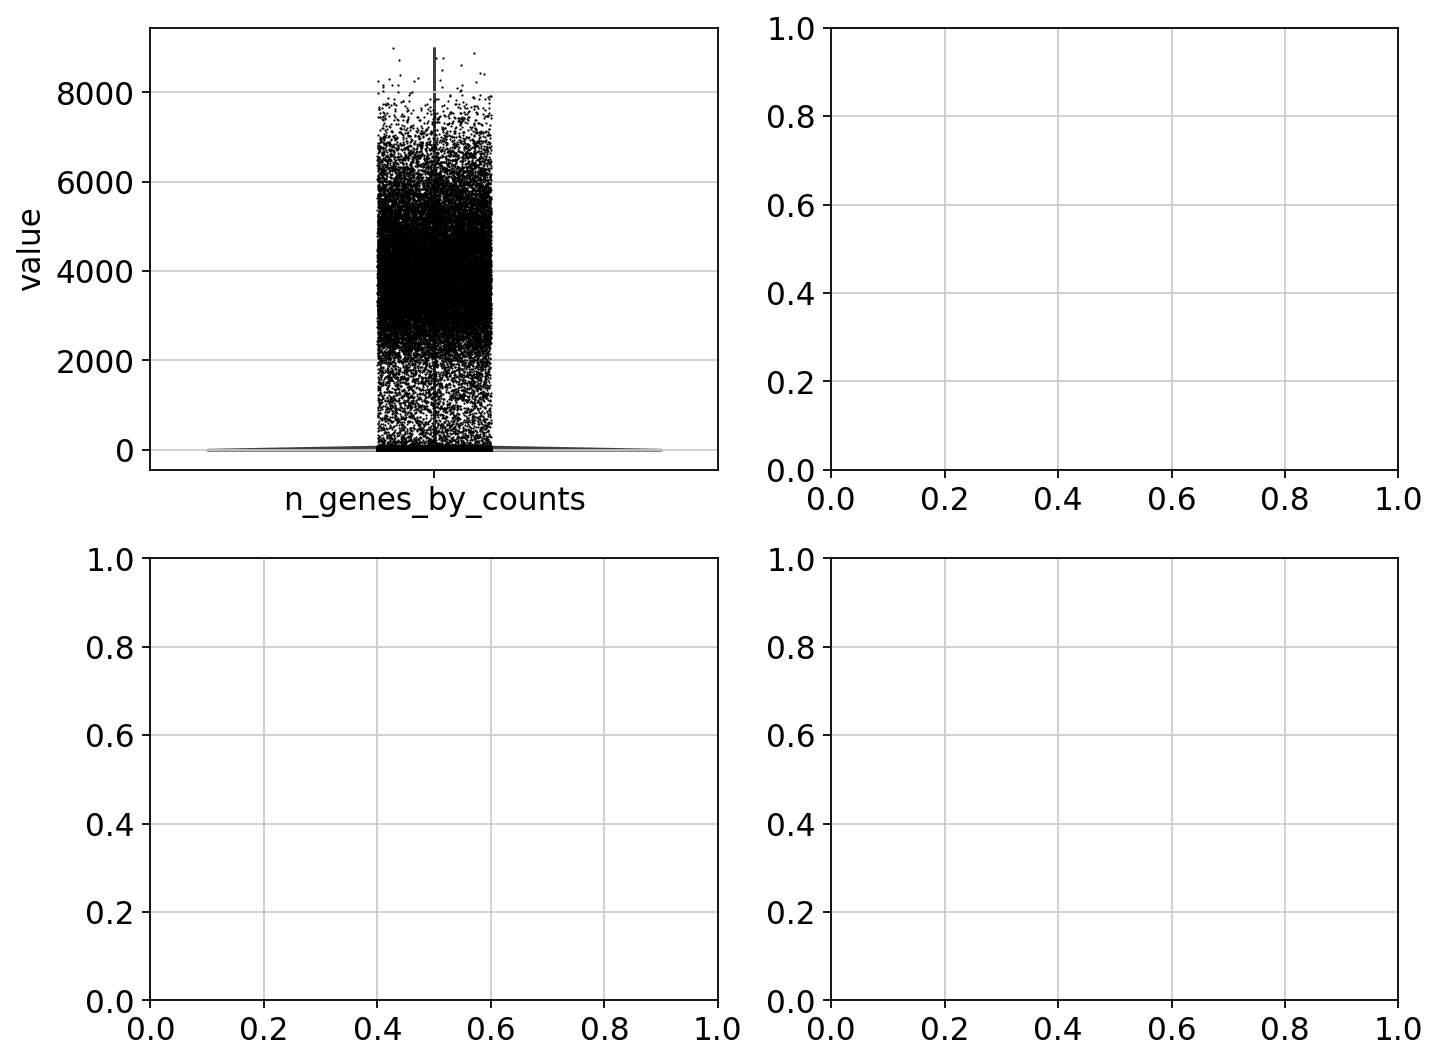

In [11]:
min_genes = 200
min_counts= 1000
min_cells = 5
max_genes = 2000
max_counts = 7000
max_mt_ratio = 0.05
min_ribo_ratio = 0.05

sc.pp.calculate_qc_metrics(adata, 
                          qc_vars=['mt', 'ribo'], 
                          percent_top=None, 
                          inplace=True)

As a sanity check, we can always copy the `adata` object to compare against the standard `scanpy.pp.recipe_seurat` function.

In [17]:
seurat_adata = sc.pp.recipe_seurat(adata, copy=True)
print(f'Number of cells after filtering: {seurat_adata.n_obs:d}.\nNumber of genes after filtering: {seurat_adata.n_vars:d}')

Number of cells after filtering: 29155.
Number of genes after filtering: 429


### Serial filtering
We need to filter on each of these thresholds. Find the way to filter on the following:

> Hint: look in the `sc.pp` module for the methods of interest. You might also need to subset datasets if there is no associated method.

1. Minimum counts
2. Mitochondiral %
3. Ribosomal %
4. Minimum genes
5. Minimum cells

In [19]:
print(f'Total number of cells: {adata.n_obs:d}')

test = sc.pp.filter_cells(adata, min_counts > min_counts)
print(f'Number of cells after min count filter: {adata.n_obs:d}')

test = adata[adata.obs.pct_counts_mt < max_mt_ratio]
print(f'Number of cells after MT filter: {test.n_obs:d}')

test = adata[adata.obs.pct_counts_ribo > min_ribo_ratio]
print(f'Number of cells after Ribo filter: {test.n_obs:d}')

test = sc.pp.filter_cells(test, min_genes = min_genes)
print(f'Number of cells after gene filter: {adata.n_obs:d}')

print(f'Total number of genes: {adata.n_vars:d}')

test = sc.pp.filter_genes(adata, min_cells = min_cells)
print(f'Number of genes after cell filter: {adata.n_vars:d}')


sc.pl.violin(test,
             ['n_genes_by_counts',
              'total_counts',
              'pct_counts_mt',
              'pct_counts_ribo'],
             jitter = 0.4,
             groupby = 'cell_type',
             rotation=90,
             save = 'cell_type.png')

Total number of cells: 1717953
Number of cells after min count filter: 1717953


AttributeError: 'DataFrame' object has no attribute 'pct_counts_mt'

> **Question**: Why do you think `scanpy.pp.recipe_seurat` reduced the dataset so much more than our filtering?

## Normalize our data

In [ ]:
adata = sc.pp.normalize_total(adata, target_sum=1e4, copy = True)
sc.pp.log1p(adata)

## Remove highly variable genes
> We extract highly variable genes (HVGs) to further reduce the dimensionality of the dataset and include only the most informative genes. Genes that vary substantially across the dataset are informative of the underlying biological variation in the data. As we only want to capture biological variation in these genes, we select highly variable genes after normalization and batch correction. HVGs are used for clustering, trajectory inference, and dimensionality reduction/visualization, while the full data set is used for computing marker genes, differential testing, cell cycle scoring, and visualizing expression values on the data.
-[CZ-BioHub](https://github.com/theislab/scanpy-demo-czbiohub/blob/master/10X_PBMC.ipynb)

In [ ]:
sc.pp.highly_variable_genes(adata)
sc.pl.highly_variable_genes(adata)

# Doublet removal
Given the small dataset that we are working with, it may not be necessary to remove any of the mulitplets. Nevertheless, it is always a good safe step to do when processing your data.

There are a number of ways that we can do this. Since there are a plethora of tools in R, you could always export the results and work in R from here. Or you can temporarily call R within JupyterLab (if you have it installed). You could also use a standalone tool from either the commandline or unique Python package (i.e., `scrublet`).

However, to maintain our data structures in a unified way, we can continue working with `scanpy` through the use of `scanpy.external.pp.scrublet`.

In [ ]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    sc.external.pp.scrublet(adata)
    adata = adata[~adata.obs.predicted_doublet]
    print(f'{adata.obs.predicted_doublet.sum()} doublets detected and removed.')

As you can see, the results of our doublet analysis suggests that no doublets need to be removed. This can be attributed to the significantly low cell count or a product of our filtering. Nevertheless, no further action is necessary for filtering and QC unless we wanted to remove ambient RNA using something like `SoupX`. As that requires us to install more packages and selectively run R from within this notebook, we are going to forego that step.

# Saving our `adata` object
Attempt to find a way to save your `adata` results to a file. Specifically an `h5ad` file.

In [ ]:
adata.write_h5ad('scanpy_filtered_3kpbmc.h5ad')

---
# Assignment

Now that you have the workflow for a *single* sample, but there is a somewhat trivial process of scaling this out to *all* samples.

As a reminder, the class dataset for this portion of the class is at: `/courses/BINF6430.202410/data/LiawData/10x_FRP_12-16-22/analysis/MMC-1/outs/per_sample_outs`

Your assignment is a choice. You can choose either of the following:
1. Apply this same process to one of the Liaw datasets, tailoring each threshold
2. Apply this same process to [*all*](https://nbisweden.github.io/workshop-archive/workshop-scRNAseq/2020-01-27/labs/compiled/scanpy/scanpy_01_qc.html) of the Liaw samples.
    * The link above will send you to a walkthrough that demonstrates how this person incorporated all of their samples.
  
## Your submission:
You are to submit a report that shows:
1. The plots for all the QC metrics.
2. The thresholds that you selected for the Liaw data.
3. An explanation as to why you selected those thresholds.
4. Supporting documentation and plots for your selections.
5. A group reflection of the assignment that details where the group had difficulties, what was clear, what was unclear, and other insights into the project. 